In [Exploring the Landscape of Spatial Robustness](https://arxiv.org/abs/1712.02779), authors find that spatial loss landscape is higly non convex, full of "valleys" and "peaks", differently from $l_\infty$ adversarial loss, where minima seem more concentrated and thus first order adversaries work well. In this notebook I want to test if using an [anti-aliased model](https://arxiv.org/abs/1904.11486) can restore/improve the smoothness of the loss landscape. 

Setup is simple: calculate validation loss on ImageNet valset with the same adversarial setup of [Exploring the Landscape of Spatial Robustness](https://arxiv.org/abs/1712.02779), check if anti-aliased model gets better accuracy (as the results from [Making Convolutional Networks Shift-Invariant Again](https://arxiv.org/abs/1904.11486) would predict) and see if the loss surface of the anti-aliased model is smoother.

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [136]:
from concurrent.futures import ProcessPoolExecutor
from glob import glob
import multiprocessing
import os
from pathlib import Path
import time
from tqdm import tqdm

import antialiased_cnns
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import torch
from torchmetrics.classification import MulticlassAccuracy
from torchvision.io import decode_image
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.transforms.functional import affine
from torchvision.io import ImageReadMode

In [ ]:
image_path_list = glob("val/**/*.JPEG", recursive=True)
label_df = pd.read_csv("labels.txt", sep=" ", header=None, names=["filename", "class_id", "class_name"])
label_list = sorted(label_df["filename"].to_list())

In [ ]:
antialiased_model = antialiased_cnns.resnet50(pretrained=True)
antialiased_model.eval().to("cuda:0")
# Taken from https://pytorch.org/vision/stable/models.html
base_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
base_model.eval().to("cuda:0")
weights = ResNet50_Weights.DEFAULT
preprocess = weights.transforms()
preprocess

In [6]:
# Grid parameters for spatial attacks, see https://arxiv.org/pdf/1712.02779v4
# Rotation from -30 to +30 degrees, 31 values
rotation_grid = np.linspace(-30, +30, 31)
# Translation from -24 to +24 pixels, 5 values - Assuming it is only Left to Right
translation_grid = np.linspace(-24, +24, 5)

In [ ]:
normal_top1_accuracy = MulticlassAccuracy(1000, top_k=1).to("cuda:0")
antialias_top1_accuracy = MulticlassAccuracy(1000, top_k=1).to("cuda:0")

criterion = torch.nn.CrossEntropyLoss()
get_label = lambda x: torch.LongTensor([int(label_list.index(x.split("\\")[-2]))]).to("cuda:0")

normal_losses = np.zeros((len(image_path_list), 
                        rotation_grid.shape[0], 
                        translation_grid.shape[0]))
antialiased_losses = np.zeros((len(image_path_list), 
                        rotation_grid.shape[0], 
                        translation_grid.shape[0]))

for img_idx, img_path in tqdm(enumerate(image_path_list), total=len(image_path_list)):
   with torch.no_grad():
      img = preprocess(
         decode_image(img_path,
                     mode=ImageReadMode.RGB))
      label = get_label(img_path)
      for iidx in range(rotation_grid.shape[0]):
         for jidk in range(translation_grid.shape[0]):
            transformed_img = affine(img.clone(), 
                                    angle=rotation_grid[iidx],
                                    translate=[0, translation_grid[jidk]],
                                    scale=1,
                                    shear=0)[None].to("cuda:0")
            normal_out = base_model(transformed_img)
            normal_losses[img_idx, iidx, jidk] = criterion(
               normal_out, label)
            normal_top1_accuracy.update(normal_out, label)

            antialias_out = antialiased_model(transformed_img)
            antialiased_losses[img_idx, iidx, jidk] = criterion(

               antialias_out, label) 
            antialias_top1_accuracy.update(antialias_out, label)
               

100%|██████████| 50000/50000 [32:37:50<00:00,  2.35s/it]    


In [ ]:
print(f"Normal top-1 accuracy {normal_top1_accuracy.compute()}") # Gives 0.5601!
print(f"Anti-aliased top-1 accuracy {antialias_top1_accuracy.compute()}") # Gives 0.7898!

tensor(0.7898, device='cuda:0')

Well, the anti-alised model is substantially better (+22.97%!)! Worth to note, this accuracy computation is not the same as in the papers. In both papers, they compute adversarial accuracy: an image is considered correct only if all its versions are correctly classified. However, from a non-adversarial point of view I think this method makes more sense, it gives a better idea of the stability.

In [ ]:
# Save results as ImageNet evaluation takes forever on your local machine
"""
import pickle
with open("intermediate_results", "wb") as f:
    pickle.dump({
        "Antialiased_losses": antialiased_losses,
        "Normal_losses": normal_losses,
        "Accuracy_normal_top1": normal_top1_accuracy,
        "Accuracy_antialiased_top1": antialias_top1_accuracy
    }, f)
"""

Now, to evaluate loss surface smoothness. I asked Claude for some metrics that are fast to compute. Total variation is even used in the original paper, so I would say those are pretty good.

In [148]:
def fast_surface_metrics(surfaces):
    """
    Compute metrics for a pair of surfaces.
    
    Args:
        surfaces: tuple of (Z1, Z2) where each is a 2D numpy array
    Returns:
        dict: Dictionary containing the metrics
    """
    Z1, Z2 = surfaces
    
    # Compute gradients
    gy1, gx1 = np.gradient(Z1)
    gradient_magnitude_1 = np.sqrt(gx1**2 + gy1**2)
    
    gy2, gx2 = np.gradient(Z2)
    gradient_magnitude_2 = np.sqrt(gx2**2 + gy2**2)
    
    return {
        'avg_gradient': (np.mean(gradient_magnitude_1), np.mean(gradient_magnitude_2)),
        'gradient_std': (np.std(gradient_magnitude_1), np.std(gradient_magnitude_2)),
        'total_variation': (
            np.sum(np.abs(np.diff(Z1, axis=0))) + np.sum(np.abs(np.diff(Z1, axis=1))),
            np.sum(np.abs(np.diff(Z2, axis=0))) + np.sum(np.abs(np.diff(Z2, axis=1)))
        )
    }
avg_gradients = []
gradient_stds = []
total_variations = []
for idx in tqdm(range(normal_losses.shape[0]), total=normal_losses.shape[0]):
    r = fast_surface_metrics((normal_losses[idx], antialiased_losses[idx]))
    avg_gradients.append(r["avg_gradient"])
    gradient_stds.append(r["gradient_std"])
    total_variations.append(r["total_variation"])

100%|██████████| 50000/50000 [00:06<00:00, 7876.29it/s]


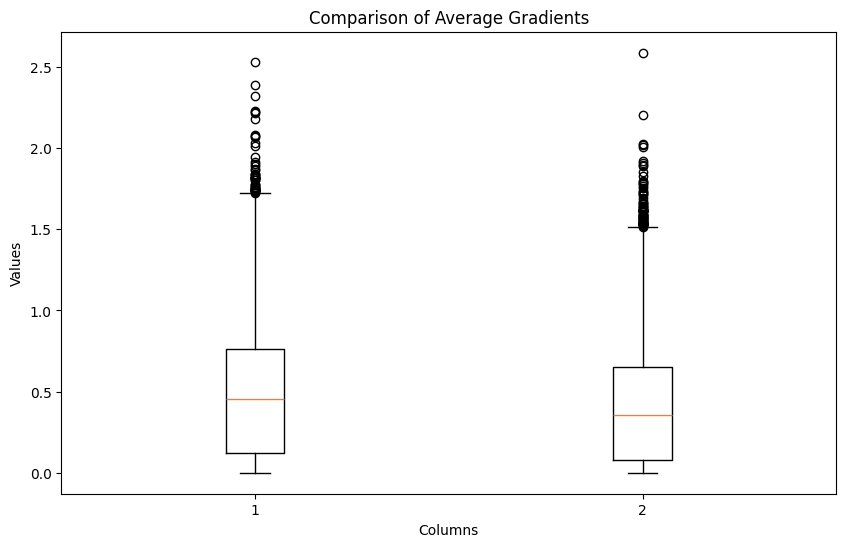

In [ ]:
plt.figure(figsize=(10, 6))
plt.boxplot([np.array([x[0] for x in avg_gradients]), np.array([x[1] for x in avg_gradients])])
plt.title('Comparison of Average Gradients')
plt.xlabel('Columns')
plt.ylabel('Values')
plt.show()
plt.savefig("Average gradients.png")

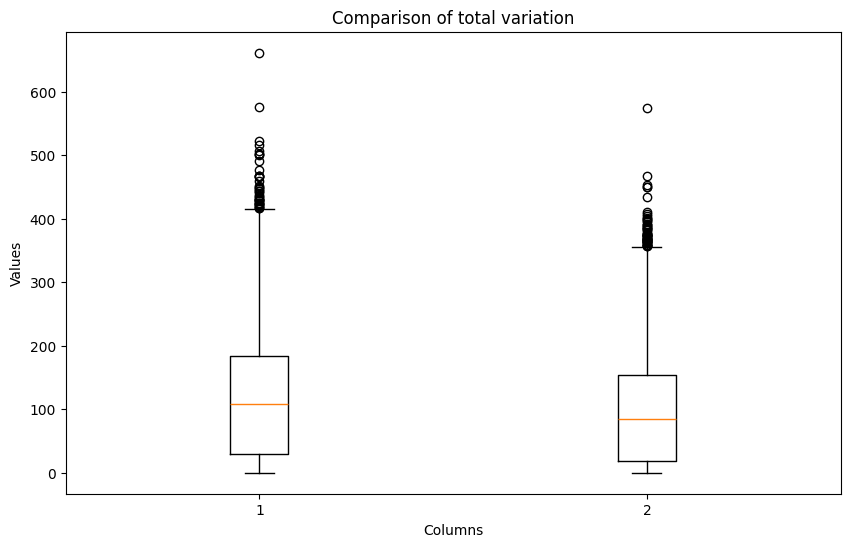

In [ ]:
plt.figure(figsize=(10, 6))
plt.boxplot([np.array([x[0] for x in total_variations]), np.array([x[1] for x in total_variations])])
plt.title('Comparison of total variation')
plt.xlabel('Columns')
plt.ylabel('Values')
plt.show()
plt.savefig("Total variations.png")

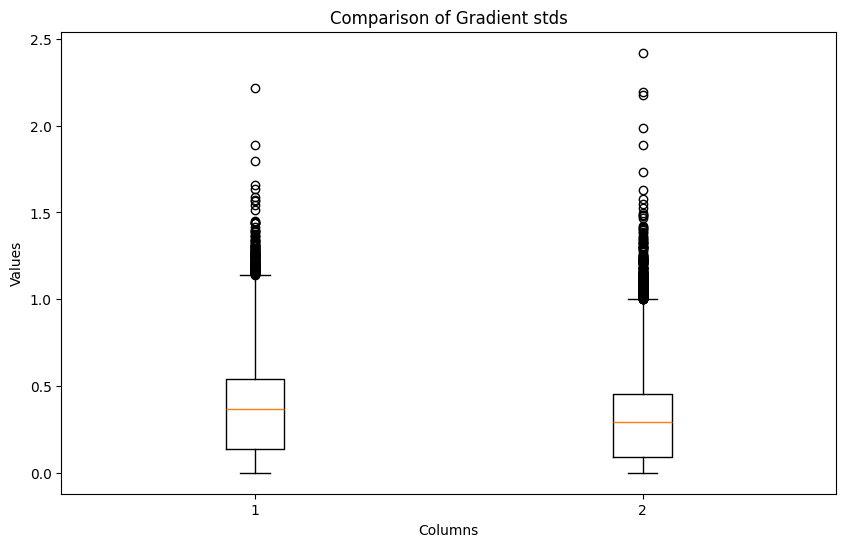

In [ ]:
plt.figure(figsize=(10, 6))
plt.boxplot([np.array([x[0] for x in gradient_stds]), np.array([x[1] for x in gradient_stds])])
plt.title('Comparison of Gradient stds')
plt.xlabel('Columns')
plt.ylabel('Values')
plt.show()
plt.savefig("Gradient stds.png")

It seems like all the smoothness metric improve for the anti-aliased model! 

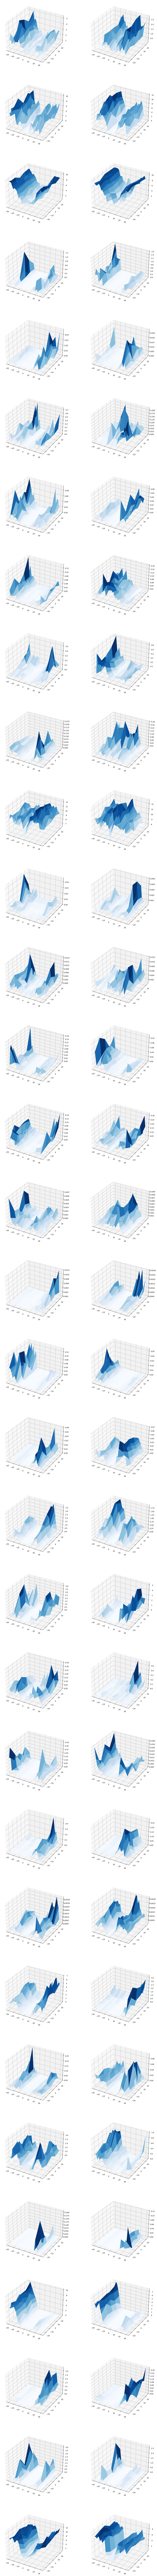

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot the surface
rows = 33
cols = 2
fig, axes = plt.subplots(nrows=rows,
                         ncols=cols,
                         figsize=(16, rows*8),
                         subplot_kw={"projection": "3d"})

for r_idx in range(rows):
       for loss_list in [normal_losses, antialiased_losses]:
              X, Y = np.meshgrid(rotation_grid, translation_grid)
              axes[r_idx, 0].plot_surface(X,
                                          Y, 
                                          normal_losses[r_idx].T, 
                                          cmap=cm.Blues)
              axes[r_idx, 1].plot_surface(X,
                                          Y,
                                          antialiased_losses[r_idx].T, 
                                          cmap=cm.Blues)

plt.show()
plt.savefig('Loss surfaces.png', dpi=200, bbox_inches='tight')


Plotting some loss surfacew gives the same idea: most surfaces seem to get smoother. Some appear to get worse. It would be interesting to see if a gradient-based spatial attack is more effective against anti-aliased networks. 